<a href="https://colab.research.google.com/github/adrianmarino/12-RNN/blob/master/lstm_and_time_distributed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Usando TimeDistributed con LSTM's

## One to One

In [0]:
%matplotlib inline

In [0]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed

from IPython.display import SVG, display
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt

Using TensorFlow backend.


### Funciones axiliares

Estas son funiones para no mostrar código repetido en los ejemplos. Recomiendo analizarlas cuando lleguemos al momento de utilizarlas, ante no por que es tratar de entender las cosas al revéz.


In [0]:
def show(model): 
  model.summary()
  dot_mode = model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg')
  display(SVG(dot_mode))


def create_model(
    input_shape, 
    hidden_neurons, 
    output_neurons,
    use_time_distributed=False
):
  model = Sequential()
  model.add(LSTM(
      hidden_neurons, 
      input_shape=input_shape, 
      return_sequences=use_time_distributed
  ))
  
  output = Dense(output_neurons)
  if use_time_distributed:
    output = TimeDistributed(output)    
  
  model.add(output)
  
  model.compile(loss='mean_squared_error', optimizer='adam')
  show(model)
  return model


def train(model, X, y, epochs, batch_size):
  history = model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)
  loss = history.history['loss'][-1]
  print(f'Loss: {loss}')

###  Prepare samples (input/output data)

Primero generamos una array de 5 valores:

In [0]:
length = 5
sequence = array([index/float(length) for index in range(length)])
print(f'Seq: {sequence}')

Seq: [0.  0.2 0.4 0.6 0.8]


Ahora, como es un toy example la red va a hacer un echo(Eco), si entra un cero sale un cero y asi sucesivamente. Pero como vamos a entranar una RNN necesitamos que cada ejemplo de input tenga el formato **(N, T, D)**. 

**LSTM**: Es un RNN con mas memoria que una SimpleRNN, es decir, recuerda secuencias mucho mas largas. 

¿Pero que es esto?
* N: Número de ejemplos presentados a la red.
* T: Es la secuencia de datos que se van a pasar por cada ejemplo N.
* D: Es la dimesionalidad de cada elemento en la secuencia. Por ejemplo: En este caso estamos pasando números. Un número se puede representar con un solo valor D=1, pero hay casos muy comunes donde la representación puede cambiar, por ejemplo con palabras.

* En este caso tenemos 5 ejemplos: [ 0, 0.2, 0.4, 0.6, 0.8] => N=5.
* En general con RNN uno quiere predecir el siguiente valor de una secuencia. Por ejemplo, tengo los ultimos 3(T=3) valores [ 0, 0.2, 0.4] y quiero predecir el siguente(0.6). En nuestro caso la secuencia es T=1 por que solo queremos hacer un eco, por eso no tiene sentido usar RNN, con una densa seria lo mismo.
* Cada valor de la secuencia se puede representar con una unica dimensión, ya que es un numero. Entonces D=1

Input Shape: **(N, T, D)** = (5, 1, 1)

¿Y en la salida que le ponemos?

la forma de la salida seria (N, D) ya que a la red se le presentan N=5 ejemplos los cuales tiene una dimensión de 1 valor numerico.

Output Shape: **(N, D)** = (5, 1)

In [0]:
X = sequence.reshape(len(sequence), 1, 1)
print(f'X {X.shape}: {X}')

y = sequence.reshape(len(sequence), 1)
print(f'y {y.shape}: {y}')

X (5, 1, 1): [[[0. ]]

 [[0.2]]

 [[0.4]]

 [[0.6]]

 [[0.8]]]
y (5, 1): [[0. ]
 [0.2]
 [0.4]
 [0.6]
 [0.8]]


### Define LSTM configuration

In [23]:
input_shape=(1,1)
print(f'input_shape: {input_shape}')


hidden_neurons = 5
print(f'hidden_neurons: {hidden_neurons}')

output_neurons = 1
print(f'output_neurons: {output_neurons}')

batch_size = 5
print(f'batch_size: {batch_size}')

epochs = 1000
print(f'epochs: {epochs}')

input_shape: (1, 1)
hidden_neurons: 5
output_neurons: 1
batch_size: 5
epochs: 1000


Ahora analicemos mejorlos parametros:

####  ¿Porque 5 neuronas ocultas?

En realidad este numero no tiene ninguna relacion con el N=5. no la busquen por que no la hay!. El numero de neuronas ocultas es arbitrario, se elige lo que mejor funciona pero: 

¿Hay alguna forma de elegir elmenor numero de neuronas que minimize el numero de parametros de la red?

Al parecer hay una forma de calcularlo pero es una aplroximación, una guia:

>$ 𝑁ℎ=𝑁𝑠 / (𝛼∗(𝑁𝑖+𝑁𝑜))$

Donde:
* $𝑁h$ = El lo que queremos averiguar, el número de neuronas de oa capa oculata de la LSTM. 
* $𝑁i$ = El número de neuronas de entrada (Que seria el tamaño de la secuencia T)
* $𝑁𝑜$ = El número de neuronas de salida (La dimencionalidad?).
* $𝑁𝑠$ = El número de ejemplos de entrenamiento(En nuestro ejemplo es N=5). 
* $𝛼$ = Es un factor de escala arbitrario entre 2 y 10.

Pero mas alla de esta explicación: ** No hay reglas claras para elegir el numero de neuronas acoltas, es algo que se descubre con prueba y error y depeden del problema a resolver.**

[Ver Referencia](https://ai.stackexchange.com/questions/3156/how-to-select-number-of-hidden-layers-and-number-of-memory-cells-in-an-lstm)

####  ¿Por que batch_size=5?

Sabemos una LSTM tiene estado pero tambien sabemos qeu keras por defecto resetea estado por cada ejemplo. Es decir que cunado termina de evaluar un ejemplose resetea el estado. Esi es asi por que el valor por defecto del parametro statefull es False. Peso si asi podriamos pensar que con un barch_size=1 es lo mismoque barch_size=5 pero no nos olvidemos que el gradiente descendente se calcula para todos los ejemplos del batch si cunato mas grande el batch_size va a ser ma exacto el calculo, asiq eucreoque ne este caso es mejor batch_size=5.

####  ¿Por que una reurona de salida?

Como hablamos, que ingrear cada valor por separado y tener un valor de salida por eso tenemos una nerona de salida. Cada salida representa un valor.

####  ¿Por que input_shape=(1,1)?

input_shapr es la forma que tienecada ejemplo en la entrada de la capa. En caso cada ejemplo
tiene una secuencia de 1 valor y cada valor tiene una dimensionalidad de 1.

input_shape=**(T, D)**


####  ¿Por que epochs=1000?
Esto tambien es arbitrario, pero la regla es elegir el menor numero de epochs para el cual se llegue al resultado esperado. 
Es decir, en este caso con 1000 epochs el resultado es el esperado. Si elegimos 10.000 estamos mejorando el error pero es necesario? El resutlado no seria el mismo?

### Create LSTM

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 3)                 60        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


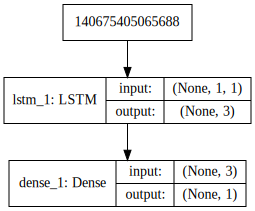

In [0]:
model = create_model(input_shape, hidden_neurons, output_neurons)

### Train LSTM

In [0]:
train(model, X, y, epochs, batch_size)

Instructions for updating:
Use tf.cast instead.
Loss: 3.0531995435012504e-05


### Evaluate

In [0]:
predictions = model.predict(X, batch_size=batch_size, verbose=0)

inputs = ["%.1f" % x for x in X]
outputs = ["%.1f" % output for output in predictions]

print(f'Inputs: {inputs}\nOutputs: {outputs}')

Inputs: ['0.0', '0.2', '0.4', '0.6', '0.8']
Outputs: ['0.0', '0.2', '0.4', '0.6', '0.8']


## Many to One

La idea en este caso es tomar como entradas toda la seguencia y en la salida tener toda la secuencia, todo en un solo paso a diferencia del caso anterior.

### Dimensionalidad de entrada

* N=1: Entonces si pasamos la secuencia completa en un solo paso, vamos a tener un solo ejemplo.
* T=5: Este unico ejemplo tiene una secuencia (temporal) de tamaño 5.
* D=1: La dimencionalidad del cada elemento de la secuenca no cambia, por que seguimos trabajando con numeros que se pueden representar en un solo valor ,como hablamos anteriormente.

=> **(N, T, D)** = (1, 5, 1)

### Dimensionalidad de salida

=> **(N, T)** = (1, 5)

* N=1: Solo hay un ejemplo, por o tanto habra un solo resultados a la salida.
*T=5. Cada elemento de salida tiene 5 valores, uno por cada elemento en la secuencia de entrada.


Una cosa a tener en cuenta es que N es *variable**! Es la cantidad de ejemplos que le pasamos a la red para entrenar. Osea, podriamos pasar mas o menos ejemplos. 
Por esta cuestion cuando hacemos model.summary() N aparece como **None**.Se refiere a que dimensión no esta definida. Osea, la red no tiene una restricción en el número de ejemplos a pasar. N es 1 para este ejemplo, por que no tenemos mas datos.

In [0]:
X = sequence.reshape(1, 5, 1)
print(f'X {X.shape}: {X}')

y = sequence.reshape(1, 5)
print(f'y {y.shape}: {y}')

X (1, 5, 1): [[[0. ]
  [0.2]
  [0.4]
  [0.6]
  [0.8]]]
y (1, 5): [[0.  0.2 0.4 0.6 0.8]]


In [0]:
input_shape=(5, 1)
print(f'input_shape: {input_shape}')

hidden_neurons = 5
print(f'hidden_neurons: {hidden_neurons}')

output_neurons = 5
print(f'output_neurons: {output_neurons}')

batch_size = 1
print(f'batch_size: {batch_size}')

epochs = 500
print(f'epochs: {epochs}')

input_shape: (5, 1)
hidden_neurons: 5
output_neurons: 5
batch_size: 1
epochs: 500


Buen aca cambiaron alguna cosas:

#### ¿Porque input_shape=(5, 1)?
 
En este caso cada ejemplo tiene una secuenca de 5 valores y cada valor una dimensión 1.

#### ¿Por que 3 neuronas ocultas?

Como ya aclaramos en el caso anterior, este numero es arbrario, se elije lo que mejor fucione, pero buscando el número mas bajo con el cual se tenga buenos resultados.

#### ¿Por que 5 neuronas de salida?

Bueno, la idea es ingresar un ejemplo con una secuencia de 5 valores y a la salida tener un eco de estos mismo 5 valores, asi que necesitamos 5 salidas.

####  ¿Por que batch_size=1?

No nos olvidemos que estamos trabajando con redes neuronales recurrentes. Como sabemos, estas infieren la salida por que recuerdan entradas anteriores, ya que poseen una memoria que puede ser mayor o menor, dependiendo de la implementación que usemos (LSTM, SimpleRNN, GRU, etc...).

Ahora bien, para tener memoria, la red tiene un estado. Al momento de entranar la red podemos elegir cuando resetear este estado. Por defecto, Keras resetea el estado luego de procesar cada secuencia. Es posible modificar este comportamiento mediante el parametro **statefull**.

* stateful = True :  Guarda el estado de cada sample del batch para luego continuar con ese estado en el proximo batch. Osea, se conserva el estado de cada Xi del batch actual y luego en el siguente batch se restaura ese estado en el element Xi. De esta manera vemos que no se puede usar shuffle ya que es necesario que los ejemplos esten ordenados, de lo contrario estariamos mezclando el estado de un ejemplo con el de otro.
* stateful = False: Es el valor por defecto y en este caso el estado se resetea en cada secuencia.

Entonces si el modelo es stateless, se resete el estado de las celas por cada secuencia. Si el modelo es statefull se propaga el estado al siguente batch. Esto significa que el estado del sample Xi en el batch actual se va a usar como estado inicial en el sample Xi2  = Xi + batch_size en el siguiente batch, por esto no hay que usar shuffle ya que perderiamos esta correlación.

Por otro lado cuando el modelo es stateless, Keras aloca un array de estados de size igual al numero de celdas que tiene la LSTM (output_dim). Luego de procesar cada secuencia este array se resetea.

En modo statefull, Keras propaga el estado de cada ejemplo entre batches. Entonces, el ejemplo i del batch 1 (Xi+bs) conocera el estado del ejemplo i del batch 0 (Xi). En este caso, la estructora donde se gardan los estados tiene la forma (batch_size, output_dim). Esta es la razon por la cual keras te fuerza a especificar el batch_size cuando se crea la capa LSTM en modo statefull.

Volviendo, en este caso no nos interesa que se conserve el estado entre ejemplos por eso no se paso statefull=True. Ademas el bach_size es 1 por que tenenos un solo ejemplo.

[Ver Referencia](http://philipperemy.github.io/keras-stateful-lstm/)

####  ¿Por que epochs=500?

Bueno en este caso como se le pasa toda la secuencia a la red necesitamenos iteraciones para llegar al resultado esperado.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 5)                 140       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 30        
Total params: 170
Trainable params: 170
Non-trainable params: 0
_________________________________________________________________


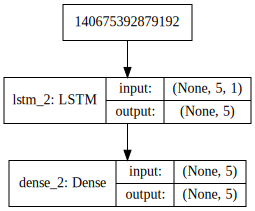

In [0]:
model = create_model(input_shape, hidden_neurons, output_neurons)

In [0]:
train(model, X, y, epochs, batch_size)

Loss: 1.5010214954118938e-14


In [0]:
predictions = model.predict(X, batch_size=batch_size, verbose=0)


inputs = ["%.1f" % x for x in X[0]]
outputs = ["%.1f" % y for y in predictions[0]]
print(f'Inputs: {inputs}\nOutputs: {outputs}')

Inputs: ['0.0', '0.2', '0.4', '0.6', '0.8']
Outputs: ['0.0', '0.2', '0.4', '0.6', '0.8']


#### Conclusiones hasta el momento

Hasta acá, podemos ver la cantidad de parametros de la LSMT no cambio. Osea, que si cambio el tamaño de la secuencia en una LSTM no cambia el número de sus hiperparametros, lo cual es un punto positivo. 

Por otro lado, podemos ver que la capa densa de salida si cambio. Ahora tenemos mas parametros a entrenar: 29 pesos + un bias.

Otro tema a tener en cuenta, es que podriamos haber usado una cadadensa es vez de una LSTM, ya que en este ejemplo no estamos usando la memoria que tiene la LSTM entre ejemplos. con una densa de 5 entradas era suficiente.


## Many-to-Many con wrapper TimeDistributed

In [0]:
X = sequence.reshape(1, 5, 1)
print(f'X {X.shape}: {X}')

y = sequence.reshape(1, 5)
print(f'y {y.shape}: {y}')

X (1, 5, 1): [[[0. ]
  [0.2]
  [0.4]
  [0.6]
  [0.8]]]
y (1, 5): [[0.  0.2 0.4 0.6 0.8]]


In [0]:
input_shape=(5, 1)
print(f'input_shape: {input_shape}')

hidden_neurons = 5
print(f'hidden_neurons: {hidden_neurons}')

output_neurons = 1
print(f'output_neurons: {output_neurons}')

batch_size = 1
print(f'batch_size: {batch_size}')

epochs = 100
print(f'epochs: {epochs}')

input_shape: (5, 1)
hidden_neurons: 5
output_neurons: 1
batch_size: 1
epochs: 100


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 5, 5)              140       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 5, 1)              6         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


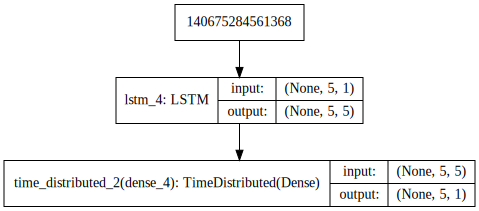

In [0]:
model = create_model(input_shape, hidden_neurons, output_neurons, use_time_distributed=True)

Bueno aca hay varias cosas nuevas:

1. use_time_distributed=True: Este parametro esta haciendo dos cosas muy importante al momento de construir el modelo:
  * Primero configura la capa LSTM para que retorne todas las salidad de la red(return_sequences=True) . Recordemos que un LSTM tiene una salida por cada elemento de la secuencia de entreada. Si tenemos una secuencia de 5, tenemos 5 steps en la red y cada uno tiene una salida. En este caso entonces la LSTM tiene 5 entradas y 5 salidas. Luego, cada salida tiene la dimensión igual al número de neuronas ocultas, que en este caso es 3. Cabe destacar que  con return_sequences=False se toma la salida del step 5 (último) de la LSTM.
  * Segundo, se agrego una capa que envuelve(wrapea) la capa densa de salida. Lo que hace esta capa, es repetirla la capa densa por cada salida de la LSTM, pero con la condición de que los pesos de la densa se compartan entre todas las salida. Es decir que si la secuencia de 100 en vez de 5 , la cantidad de parametro no cambia, otro punto positivo.
 
 2. El número de salidas que elegimos para la capa densa era 1, pero se puede ver que al usar la capa TimeDistributed se modifico la salida, ya que al tener una densa por cada salida de la LSTM, ahora la red tiene 5 salida en vez de una.



## Conclusiones finales

Saquemos conclusiones ahora que vimos todos los ejemplos:

* En este último ejemplo tenemos la misma dimensionalidad que el primer, pero a su favor, permite manejar las secuencias de una forma mas natural que el pimer caso, donde tenemos que entrenar la red pasando cada valor de la secuencia por separado.

* Por otro lado se simplifica la red. El ejemplo many-one  tiene la misma dimensionalidad de entrada y salida que este ultimo ejemplo, pero la diferencia importante es que bajamos el numero de parametros a entrenar. Esto se traduce en menor uso de recursos y menor tiempo de entrenamiento.